In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance
from pandas import read_gbq
import datetime
import pytz

In [2]:
import pandas as pd
from google.oauth2 import service_account
import pandas as pd
import pandas_gbq as gbq 
import json
from pandas_gbq import to_gbq, read_gbq
import matplotlib.pyplot as plt
import seaborn as sns

credentials_path = '../../token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [3]:
df = read_gbq(f"""

SELECT *
FROM capstone-402105.capstone.cri_compustat_yfinance

""",project_id='capstone-402105', dialect='standard')


Downloading: 100%|██████████|


In [6]:
df = pd.read_pickle('cri_compustat_yfinance.pkl')

In [9]:
cols = list(df.columns)

df.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
date2020 = datetime.datetime(2020,1,1).replace(tzinfo=pytz.UTC)
train_df = df[df["EventDate"] < date2020]
validation_df = df[(df["EventDate"] >= date2020) & (df["EventDate"] < date2022)]
test_df = df[df["EventDate"] >= date2022]

In [10]:
train_df = train_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])
validation_df = validation_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])
test_df = test_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])

In [11]:
x_train = train_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_train = train_df['Default_12']
x_validation = validation_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_validation = validation_df['Default_12']
x_test = test_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_test = test_df["Default_12"]

In [12]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_validation.shape, y_validation.shape

((493390, 45), (493390,), (33628, 45), (33628,), (52797, 45), (52797,))

In [6]:
x_train.columns

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'DTDmedianNonFin', 'current_ratio', 'quick_ratio', 'cash_ratio',
       'net_working_capital', 'debt_ratio', 'debt_to_equity_ratio',
       'equity_ratio', 'cashflow_to_debt_ratio', 'net_profit_margin',
       'return_on_assets', 'asset_turnover', 'inventory_turnover',
       'days_in_inventory', 'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio',
       'Rolling_Sortino', 'macd', 'macd_h', 'macd_s', 'rsi'],
      dtype='object')

In [14]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'auc', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-08 23:21:21,400] A new study created in memory with name: no-name-6f44f66b-10b5-49a6-9b32-980c46990088
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:21:35,620] Trial 0 finished with value: 0.9118888698944543 and parameters: {'num_leaves': 188, 'lambda_l1': 2.0743714729858267, 'lambda_l2': 0.12000703147224254, 'feature_fraction': 0.519512441769413, 'min_child_samples': 8, 'learning_rate': 2.450106130257268e-05, 'max_depth': 161, 'num_boost_round': 399}. Best is trial 0 with value: 0.9118888698944543.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:22:03,379] Trial 1 finished with value: 0.901010630551915 and parameters: {'num_leaves': 253, 'lambda_l1': 6.295124032826646e-08, 'lambda_l2': 4.0125756538332367e-05, 'feature_fraction': 0.5791503563861121, 'min_child_samples': 46, 'learning_rate': 0.0017884166003089492, 'max_depth': 170, 'num_boost_round': 332}. Best is trial 0 with value: 0.9118888698944543.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2023-11-08 23:22:27,310] Trial 2 finished with value: 0.752717787021736 and parameters: {'num_leaves': 194, 'lambda_l1': 9.116858400370072, 'lambda_l2': 0.003280106698882186, 'feature_fraction': 0.6993495515058998, 'min_child_samples': 21, 'learning_rate': 0.032197951634914256, 'max_depth': 76, 'num_boost_round': 328}. Best is trial 0 with value: 0.9118888698944543.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:23:08,085] Trial 3 finished with value: 0.8846438860080663 and parameters: {'num_leaves': 210, 'lambda_l1': 1.368491655313175e-08, 'lambda_l2': 3.226969896378711e-05, 'feature_fraction': 0.7416072915262331, 'min_child_samples': 10, 'learning_rate': 7.350844120989483e-07, 'max_depth': 231, 'num_boost_round': 377}. Best is trial 0 with value: 0.9118888698944543.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:23:14,604] Trial 4 finished with value: 0.9129005134828829 and parameters: {'num_leaves': 67, 'lambda_l1': 0.028283910717296124, 'lambda_l2': 2.6194222452733523e-08, 'feature_fraction': 0.4557549653074592, 'min_child_samples': 5, 'learning_rate': 0.00010580690772458076, 'max_depth': 60, 'num_boost_round': 122}. Best is trial 4 with value: 0.9129005134828829.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stop

[I 2023-11-08 23:23:19,923] Trial 5 finished with value: 0.5416705605257659 and parameters: {'num_leaves': 94, 'lambda_l1': 2.516795417240876e-07, 'lambda_l2': 0.010972554104256802, 'feature_fraction': 0.8069567802522826, 'min_child_samples': 18, 'learning_rate': 2.089156037027476, 'max_depth': 104, 'num_boost_round': 168}. Best is trial 4 with value: 0.9129005134828829.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:23:28,585] Trial 6 finished with value: 0.9396346737072705 and parameters: {'num_leaves': 185, 'lambda_l1': 0.21010397917523188, 'lambda_l2': 6.129935996083479e-08, 'feature_fraction': 0.41700365996337607, 'min_child_samples': 71, 'learning_rate': 3.5540081251951865e-08, 'max_depth': 2, 'num_boost_round': 482}. Best is trial 6 with value: 0.9396346737072705.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:23:46,915] Trial 7 finished with value: 0.7385269182796107 and parameters: {'num_leaves': 66, 'lambda_l1': 0.0064232251166523105, 'lambda_l2': 1.7933556571945993e-07, 'feature_fraction': 0.9721123143074241, 'min_child_samples': 17, 'learning_rate': 1.366521200645062e-07, 'max_depth': 180, 'num_boost_round': 374}. Best is trial 6 with value: 0.9396346737072705.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:23:56,140] Trial 8 finished with value: 0.9049865456088032 and parameters: {'num_leaves': 229, 'lambda_l1': 7.009382780858727e-07, 'lambda_l2': 0.9623633320045645, 'feature_fraction': 0.7805036411102173, 'min_child_samples': 85, 'learning_rate': 3.134648252289281e-07, 'max_depth': 256, 'num_boost_round': 181}. Best is trial 6 with value: 0.9396346737072705.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


[I 2023-11-08 23:24:22,508] Trial 9 finished with value: 0.8818009256621143 and parameters: {'num_leaves': 174, 'lambda_l1': 2.2429035325544884e-06, 'lambda_l2': 2.1881358687877074e-07, 'feature_fraction': 0.9325531305990665, 'min_child_samples': 67, 'learning_rate': 0.010026362839647302, 'max_depth': 144, 'num_boost_round': 331}. Best is trial 6 with value: 0.9396346737072705.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:24:27,732] Trial 10 finished with value: 0.9395573663583238 and parameters: {'num_leaves': 133, 'lambda_l1': 0.00011399485669574674, 'lambda_l2': 2.4264190182918722e-06, 'feature_fraction': 0.4037299383966863, 'min_child_samples': 93, 'learning_rate': 8.141083372974259e-08, 'max_depth': 2, 'num_boost_round': 467}. Best is trial 6 with value: 0.9396346737072705.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:24:34,343] Trial 11 finished with value: 0.9384977301650617 and parameters: {'num_leaves': 5, 'lambda_l1': 0.00010141224277182343, 'lambda_l2': 2.345994893860971e-06, 'feature_fraction': 0.4612226735959027, 'min_child_samples': 97, 'learning_rate': 2.617097038027174e-08, 'max_depth': 3, 'num_boost_round': 495}. Best is trial 6 with value: 0.9396346737072705.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:24:39,772] Trial 12 finished with value: 0.9397537054976226 and parameters: {'num_leaves': 143, 'lambda_l1': 9.009741183252639e-05, 'lambda_l2': 1.3960239121959388e-08, 'feature_fraction': 0.4188450231930575, 'min_child_samples': 71, 'learning_rate': 1.0535556440623728e-08, 'max_depth': 2, 'num_boost_round': 495}. Best is trial 12 with value: 0.9397537054976226.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:24:52,990] Trial 13 finished with value: 0.9399449161395711 and parameters: {'num_leaves': 147, 'lambda_l1': 0.004579111905530194, 'lambda_l2': 1.1271701698620912e-08, 'feature_fraction': 0.4008157591102936, 'min_child_samples': 67, 'learning_rate': 2.087341445431617e-08, 'max_depth': 50, 'num_boost_round': 450}. Best is trial 13 with value: 0.9399449161395711.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:25:09,319] Trial 14 finished with value: 0.9244569807713007 and parameters: {'num_leaves': 143, 'lambda_l1': 0.0012258588882166834, 'lambda_l2': 2.2706422740869226e-08, 'feature_fraction': 0.5608125951800458, 'min_child_samples': 48, 'learning_rate': 5.760598937502743e-06, 'max_depth': 48, 'num_boost_round': 434}. Best is trial 13 with value: 0.9399449161395711.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:25:19,697] Trial 15 finished with value: 0.9300451434396388 and parameters: {'num_leaves': 108, 'lambda_l1': 1.8917517214619063e-05, 'lambda_l2': 1.0913397896357764e-08, 'feature_fraction': 0.5160088860326141, 'min_child_samples': 65, 'learning_rate': 1.5924731353457527e-08, 'max_depth': 40, 'num_boost_round': 244}. Best is trial 13 with value: 0.9399449161395711.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:25:36,037] Trial 16 finished with value: 0.9227346920685573 and parameters: {'num_leaves': 159, 'lambda_l1': 0.0010905128233000213, 'lambda_l2': 1.1217506096319504e-06, 'feature_fraction': 0.6170063755807358, 'min_child_samples': 35, 'learning_rate': 9.822425152390861e-07, 'max_depth': 105, 'num_boost_round': 430}. Best is trial 13 with value: 0.9399449161395711.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:25:43,476] Trial 17 finished with value: 0.93489277641651 and parameters: {'num_leaves': 104, 'lambda_l1': 9.139481660119709e-06, 'lambda_l2': 1.2887288772507358e-08, 'feature_fraction': 0.40003947465301, 'min_child_samples': 82, 'learning_rate': 2.9176734969314233e-06, 'max_depth': 30, 'num_boost_round': 258}. Best is trial 13 with value: 0.9399449161395711.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:25:53,211] Trial 18 finished with value: 0.9141809916361173 and parameters: {'num_leaves': 40, 'lambda_l1': 0.015103264400476695, 'lambda_l2': 2.817987679176137e-07, 'feature_fraction': 0.4838004377924145, 'min_child_samples': 54, 'learning_rate': 1.6344035186594725e-05, 'max_depth': 86, 'num_boost_round': 431}. Best is trial 13 with value: 0.9399449161395711.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:26:11,783] Trial 19 finished with value: 0.9207994124388221 and parameters: {'num_leaves': 144, 'lambda_l1': 0.0002041627705695174, 'lambda_l2': 2.3192785383236166e-05, 'feature_fraction': 0.6337574476570663, 'min_child_samples': 75, 'learning_rate': 1.4281287899499646e-08, 'max_depth': 30, 'num_boost_round': 491}. Best is trial 13 with value: 0.9399449161395711.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:26:29,179] Trial 20 finished with value: 0.9323040882354803 and parameters: {'num_leaves': 124, 'lambda_l1': 2.2265507186490005e-05, 'lambda_l2': 0.00028823779252486225, 'feature_fraction': 0.5140919733677899, 'min_child_samples': 58, 'learning_rate': 3.666358577650364e-07, 'max_depth': 117, 'num_boost_round': 450}. Best is trial 13 with value: 0.9399449161395711.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:26:44,952] Trial 21 finished with value: 0.9403477247833052 and parameters: {'num_leaves': 163, 'lambda_l1': 0.1317669686376496, 'lambda_l2': 7.596556309056475e-08, 'feature_fraction': 0.41581296064470685, 'min_child_samples': 72, 'learning_rate': 1.0311783453451462e-08, 'max_depth': 15, 'num_boost_round': 472}. Best is trial 21 with value: 0.9403477247833052.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:27:02,562] Trial 22 finished with value: 0.937382566907896 and parameters: {'num_leaves': 162, 'lambda_l1': 0.1368828580736441, 'lambda_l2': 1.2041481438447585e-07, 'feature_fraction': 0.4524035872204376, 'min_child_samples': 80, 'learning_rate': 1.0855285715825001e-08, 'max_depth': 26, 'num_boost_round': 406}. Best is trial 21 with value: 0.9403477247833052.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:27:22,953] Trial 23 finished with value: 0.9389278274798817 and parameters: {'num_leaves': 162, 'lambda_l1': 0.002004691360214741, 'lambda_l2': 6.552571124525792e-08, 'feature_fraction': 0.44823195078929995, 'min_child_samples': 61, 'learning_rate': 1.1192333726820926e-07, 'max_depth': 70, 'num_boost_round': 458}. Best is trial 21 with value: 0.9403477247833052.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:27:35,125] Trial 24 finished with value: 0.9370591550009181 and parameters: {'num_leaves': 116, 'lambda_l1': 0.050159049178948034, 'lambda_l2': 6.027622107459437e-07, 'feature_fraction': 0.4181944156636528, 'min_child_samples': 89, 'learning_rate': 1.128702117158115e-07, 'max_depth': 22, 'num_boost_round': 375}. Best is trial 21 with value: 0.9403477247833052.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:27:55,171] Trial 25 finished with value: 0.9347190406544216 and parameters: {'num_leaves': 207, 'lambda_l1': 0.008480093667592673, 'lambda_l2': 4.962505429432986e-08, 'feature_fraction': 0.4929654639482228, 'min_child_samples': 39, 'learning_rate': 1.8971479269514732e-06, 'max_depth': 55, 'num_boost_round': 499}. Best is trial 21 with value: 0.9403477247833052.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:28:08,438] Trial 26 finished with value: 0.9261486251195066 and parameters: {'num_leaves': 87, 'lambda_l1': 0.43915020013236616, 'lambda_l2': 1.1722238893930654e-08, 'feature_fraction': 0.5454331079896291, 'min_child_samples': 77, 'learning_rate': 1.1081412533878582e-08, 'max_depth': 15, 'num_boost_round': 407}. Best is trial 21 with value: 0.9403477247833052.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:28:30,949] Trial 27 finished with value: 0.9337529837091065 and parameters: {'num_leaves': 145, 'lambda_l1': 0.0037799356859031692, 'lambda_l2': 8.37304680562438e-07, 'feature_fraction': 0.4874133636150809, 'min_child_samples': 70, 'learning_rate': 8.340873200584654e-08, 'max_depth': 88, 'num_boost_round': 461}. Best is trial 21 with value: 0.9403477247833052.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:28:42,588] Trial 28 finished with value: 0.9403700115866052 and parameters: {'num_leaves': 231, 'lambda_l1': 0.0009554960213714971, 'lambda_l2': 6.195825208110971e-06, 'feature_fraction': 0.4007227003742236, 'min_child_samples': 61, 'learning_rate': 4.731979768853754e-07, 'max_depth': 42, 'num_boost_round': 289}. Best is trial 28 with value: 0.9403700115866052.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:28:53,988] Trial 29 finished with value: 0.9303789389708815 and parameters: {'num_leaves': 255, 'lambda_l1': 0.6889330042995058, 'lambda_l2': 6.346833209119722e-06, 'feature_fraction': 0.5372187335399766, 'min_child_samples': 60, 'learning_rate': 7.442366023222882e-06, 'max_depth': 147, 'num_boost_round': 256}. Best is trial 28 with value: 0.9403700115866052.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:29:07,364] Trial 30 finished with value: 0.9343576398781823 and parameters: {'num_leaves': 221, 'lambda_l1': 0.03232699233293785, 'lambda_l2': 3.145022596529521e-07, 'feature_fraction': 0.4819171786338601, 'min_child_samples': 38, 'learning_rate': 3.58061867184645e-07, 'max_depth': 194, 'num_boost_round': 297}. Best is trial 28 with value: 0.9403700115866052.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:29:22,097] Trial 31 finished with value: 0.9384701882348473 and parameters: {'num_leaves': 183, 'lambda_l1': 0.00035466548419495225, 'lambda_l2': 6.83462159804471e-08, 'feature_fraction': 0.4387147587275668, 'min_child_samples': 74, 'learning_rate': 6.136096056841181e-08, 'max_depth': 46, 'num_boost_round': 400}. Best is trial 28 with value: 0.9403700115866052.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:29:37,364] Trial 32 finished with value: 0.9428439733824656 and parameters: {'num_leaves': 241, 'lambda_l1': 0.0006812648570966692, 'lambda_l2': 6.992896414669957e-08, 'feature_fraction': 0.42870749496732385, 'min_child_samples': 52, 'learning_rate': 3.5631965377096696e-08, 'max_depth': 18, 'num_boost_round': 292}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:29:49,349] Trial 33 finished with value: 0.9400479926048335 and parameters: {'num_leaves': 240, 'lambda_l1': 0.0007889539581682771, 'lambda_l2': 3.9776466904747895e-06, 'feature_fraction': 0.45549855095439706, 'min_child_samples': 52, 'learning_rate': 1.1372369850726065e-06, 'max_depth': 39, 'num_boost_round': 287}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:30:02,923] Trial 34 finished with value: 0.9340171329800367 and parameters: {'num_leaves': 237, 'lambda_l1': 0.0007862440583431636, 'lambda_l2': 9.7583318494471e-06, 'feature_fraction': 0.5088485079577113, 'min_child_samples': 47, 'learning_rate': 1.6636741140204562e-06, 'max_depth': 66, 'num_boost_round': 288}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:30:11,852] Trial 35 finished with value: 0.9161047479755098 and parameters: {'num_leaves': 242, 'lambda_l1': 7.44818203996048, 'lambda_l2': 9.922489402314596e-05, 'feature_fraction': 0.4532149592745074, 'min_child_samples': 28, 'learning_rate': 7.805737418302597e-05, 'max_depth': 35, 'num_boost_round': 218}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:30:25,682] Trial 36 finished with value: 0.9278374836173001 and parameters: {'num_leaves': 202, 'lambda_l1': 0.0006933137335586714, 'lambda_l2': 3.579834344893219e-06, 'feature_fraction': 0.5707095179779657, 'min_child_samples': 53, 'learning_rate': 5.562837870484264e-07, 'max_depth': 20, 'num_boost_round': 313}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:30:38,047] Trial 37 finished with value: 0.9391781741283137 and parameters: {'num_leaves': 226, 'lambda_l1': 0.016333564581988785, 'lambda_l2': 1.305057417667373e-05, 'feature_fraction': 0.4751423097159467, 'min_child_samples': 45, 'learning_rate': 2.324688100782634e-07, 'max_depth': 71, 'num_boost_round': 276}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:30:52,886] Trial 38 finished with value: 0.9388960434592665 and parameters: {'num_leaves': 245, 'lambda_l1': 0.078745514687178, 'lambda_l2': 6.62164820700185e-05, 'feature_fraction': 0.44346562516057836, 'min_child_samples': 56, 'learning_rate': 1.1428572467077257e-06, 'max_depth': 81, 'num_boost_round': 346}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:31:03,003] Trial 39 finished with value: 0.9266301973521757 and parameters: {'num_leaves': 217, 'lambda_l1': 0.0030795073927191476, 'lambda_l2': 1.389289152431151e-06, 'feature_fraction': 0.5336587540160188, 'min_child_samples': 49, 'learning_rate': 3.909439878085603e-08, 'max_depth': 94, 'num_boost_round': 230}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:31:16,283] Trial 40 finished with value: 0.926759106248536 and parameters: {'num_leaves': 196, 'lambda_l1': 0.0003441310013178045, 'lambda_l2': 4.2371639250020363e-07, 'feature_fraction': 0.4337204934519253, 'min_child_samples': 41, 'learning_rate': 3.440609197274608e-05, 'max_depth': 17, 'num_boost_round': 346}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:31:24,372] Trial 41 finished with value: 0.940871844549547 and parameters: {'num_leaves': 235, 'lambda_l1': 0.004727723837612731, 'lambda_l2': 4.652861753493934e-08, 'feature_fraction': 0.408303812124678, 'min_child_samples': 65, 'learning_rate': 3.860766642744156e-08, 'max_depth': 50, 'num_boost_round': 191}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:31:29,218] Trial 42 finished with value: 0.9366243090774403 and parameters: {'num_leaves': 233, 'lambda_l1': 0.009757942165034571, 'lambda_l2': 1.2669054454440546e-07, 'feature_fraction': 0.42680155391862695, 'min_child_samples': 62, 'learning_rate': 2.3020920925891612e-07, 'max_depth': 55, 'num_boost_round': 111}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:31:39,705] Trial 43 finished with value: 0.9396903907155204 and parameters: {'num_leaves': 212, 'lambda_l1': 0.0024525446030350196, 'lambda_l2': 3.9619045933052885e-08, 'feature_fraction': 0.46509548939021683, 'min_child_samples': 64, 'learning_rate': 4.555433901662966e-08, 'max_depth': 39, 'num_boost_round': 202}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:31:47,819] Trial 44 finished with value: 0.9407810511520124 and parameters: {'num_leaves': 256, 'lambda_l1': 0.023302487163752574, 'lambda_l2': 3.9829020359869885e-06, 'feature_fraction': 0.40735669918100376, 'min_child_samples': 53, 'learning_rate': 3.756548153406753e-08, 'max_depth': 15, 'num_boost_round': 178}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:31:53,750] Trial 45 finished with value: 0.9306086450003482 and parameters: {'num_leaves': 255, 'lambda_l1': 0.09599687339402539, 'lambda_l2': 5.210935481385918e-07, 'feature_fraction': 0.4212036862444978, 'min_child_samples': 57, 'learning_rate': 5.0895962939769955e-08, 'max_depth': 11, 'num_boost_round': 139}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:32:00,104] Trial 46 finished with value: 0.9351614843517516 and parameters: {'num_leaves': 190, 'lambda_l1': 0.035137837867671114, 'lambda_l2': 1.3397284686870315e-07, 'feature_fraction': 0.41154625668300204, 'min_child_samples': 44, 'learning_rate': 3.186627656020234e-08, 'max_depth': 12, 'num_boost_round': 157}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:32:08,400] Trial 47 finished with value: 0.9326723270081866 and parameters: {'num_leaves': 226, 'lambda_l1': 0.019060406192538844, 'lambda_l2': 1.6821429672503415e-06, 'feature_fraction': 0.5070134122881123, 'min_child_samples': 31, 'learning_rate': 2.1377485324560744e-07, 'max_depth': 61, 'num_boost_round': 190}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:32:14,679] Trial 48 finished with value: 0.9376873642689358 and parameters: {'num_leaves': 251, 'lambda_l1': 0.24014068039047462, 'lambda_l2': 3.0355785553094586e-08, 'feature_fraction': 0.4001096931349077, 'min_child_samples': 69, 'learning_rate': 1.2636054668509194e-07, 'max_depth': 28, 'num_boost_round': 157}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:32:26,471] Trial 49 finished with value: 0.9393584946277407 and parameters: {'num_leaves': 177, 'lambda_l1': 0.005504716764537545, 'lambda_l2': 1.8969643723168117e-07, 'feature_fraction': 0.43411549476707945, 'min_child_samples': 51, 'learning_rate': 2.7524072754083273e-08, 'max_depth': 199, 'num_boost_round': 317}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:32:31,011] Trial 50 finished with value: 0.9123143452301808 and parameters: {'num_leaves': 202, 'lambda_l1': 0.04716462196978228, 'lambda_l2': 6.660084057556533e-07, 'feature_fraction': 0.47351108098027583, 'min_child_samples': 73, 'learning_rate': 6.237991888377969e-07, 'max_depth': 7, 'num_boost_round': 132}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:32:43,885] Trial 51 finished with value: 0.9403901456873136 and parameters: {'num_leaves': 240, 'lambda_l1': 0.001298984309689638, 'lambda_l2': 4.732333071803973e-06, 'feature_fraction': 0.4584360929058281, 'min_child_samples': 54, 'learning_rate': 7.259772287910904e-08, 'max_depth': 40, 'num_boost_round': 268}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:32:54,779] Trial 52 finished with value: 0.9408106824700363 and parameters: {'num_leaves': 234, 'lambda_l1': 0.0016245381065655394, 'lambda_l2': 2.337563378063932e-05, 'feature_fraction': 0.42564210098816424, 'min_child_samples': 65, 'learning_rate': 2.31681754648969e-08, 'max_depth': 46, 'num_boost_round': 268}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:33:04,954] Trial 53 finished with value: 0.9390654738161718 and parameters: {'num_leaves': 232, 'lambda_l1': 0.007297768705965414, 'lambda_l2': 2.0851224283329787e-05, 'feature_fraction': 0.4002306975997515, 'min_child_samples': 64, 'learning_rate': 6.901925952245932e-08, 'max_depth': 42, 'num_boost_round': 270}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:33:14,263] Trial 54 finished with value: 0.9385333763873851 and parameters: {'num_leaves': 248, 'lambda_l1': 0.00190400151739684, 'lambda_l2': 3.848425546976091e-06, 'feature_fraction': 0.4641414016939734, 'min_child_samples': 58, 'learning_rate': 2.189219940940485e-08, 'max_depth': 52, 'num_boost_round': 226}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:33:25,604] Trial 55 finished with value: 0.9338320005571701 and parameters: {'num_leaves': 218, 'lambda_l1': 0.00016904033525476012, 'lambda_l2': 8.217963844416724e-06, 'feature_fraction': 0.4959044692071992, 'min_child_samples': 67, 'learning_rate': 1.4836236971523957e-07, 'max_depth': 32, 'num_boost_round': 244}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:33:35,665] Trial 56 finished with value: 0.9415856554029669 and parameters: {'num_leaves': 240, 'lambda_l1': 0.0013161941773849, 'lambda_l2': 3.6866284936868875e-05, 'feature_fraction': 0.4388886109509189, 'min_child_samples': 55, 'learning_rate': 4.334232009442449e-07, 'max_depth': 59, 'num_boost_round': 201}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:33:45,991] Trial 57 finished with value: 0.9398336087526356 and parameters: {'num_leaves': 240, 'lambda_l1': 0.00414100259155859, 'lambda_l2': 3.4089143704051905e-05, 'feature_fraction': 0.4387601123453038, 'min_child_samples': 42, 'learning_rate': 2.3180423391548347e-08, 'max_depth': 102, 'num_boost_round': 206}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:33:52,973] Trial 58 finished with value: 0.94074483509665 and parameters: {'num_leaves': 213, 'lambda_l1': 0.0003517356656837514, 'lambda_l2': 0.000429419208478395, 'feature_fraction': 0.47152407526186746, 'min_child_samples': 55, 'learning_rate': 4.745965604859534e-08, 'max_depth': 77, 'num_boost_round': 175}. Best is trial 32 with value: 0.9428439733824656.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:34:01,141] Trial 59 finished with value: 0.9432574189095928 and parameters: {'num_leaves': 214, 'lambda_l1': 0.0003502371247416084, 'lambda_l2': 0.001165287890120001, 'feature_fraction': 0.428169444877706, 'min_child_samples': 49, 'learning_rate': 1.8452013512430685e-07, 'max_depth': 118, 'num_boost_round': 171}. Best is trial 59 with value: 0.9432574189095928.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:34:06,677] Trial 60 finished with value: 0.9170191400586296 and parameters: {'num_leaves': 224, 'lambda_l1': 7.247567970433231e-05, 'lambda_l2': 0.0010567578693652996, 'feature_fraction': 0.5216940583186754, 'min_child_samples': 49, 'learning_rate': 2.1644957298326869e-07, 'max_depth': 127, 'num_boost_round': 103}. Best is trial 59 with value: 0.9432574189095928.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:34:15,645] Trial 61 finished with value: 0.9428251055773992 and parameters: {'num_leaves': 212, 'lambda_l1': 0.0005555241348014474, 'lambda_l2': 0.00011918339462668723, 'feature_fraction': 0.42843288714749517, 'min_child_samples': 51, 'learning_rate': 3.811273415227726e-08, 'max_depth': 62, 'num_boost_round': 176}. Best is trial 59 with value: 0.9432574189095928.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:34:22,629] Trial 62 finished with value: 0.9416851862404315 and parameters: {'num_leaves': 204, 'lambda_l1': 0.0018868378484323965, 'lambda_l2': 0.00015284298485185413, 'feature_fraction': 0.42522899580644824, 'min_child_samples': 50, 'learning_rate': 1.7530977476114443e-08, 'max_depth': 64, 'num_boost_round': 162}. Best is trial 59 with value: 0.9432574189095928.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:34:28,660] Trial 63 finished with value: 0.9418625942598818 and parameters: {'num_leaves': 197, 'lambda_l1': 0.0005014947205400133, 'lambda_l2': 0.00012329532069088638, 'feature_fraction': 0.4292058937378947, 'min_child_samples': 50, 'learning_rate': 1.673003028199095e-08, 'max_depth': 63, 'num_boost_round': 158}. Best is trial 59 with value: 0.9432574189095928.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:34:36,309] Trial 64 finished with value: 0.9337924921331383 and parameters: {'num_leaves': 195, 'lambda_l1': 0.0005100586337792975, 'lambda_l2': 0.0035920258131819363, 'feature_fraction': 0.49525253921234813, 'min_child_samples': 36, 'learning_rate': 1.0284691414851417e-08, 'max_depth': 64, 'num_boost_round': 159}. Best is trial 59 with value: 0.9432574189095928.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:34:42,430] Trial 65 finished with value: 0.9310603326558652 and parameters: {'num_leaves': 184, 'lambda_l1': 0.00018606091452463445, 'lambda_l2': 0.00013704123494668837, 'feature_fraction': 0.4405075135977741, 'min_child_samples': 44, 'learning_rate': 1.022775830014728e-07, 'max_depth': 97, 'num_boost_round': 140}. Best is trial 59 with value: 0.9432574189095928.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:34:50,102] Trial 66 finished with value: 0.942844226641594 and parameters: {'num_leaves': 205, 'lambda_l1': 7.380635678102984e-05, 'lambda_l2': 0.0002007771498971749, 'feature_fraction': 0.4269093049013543, 'min_child_samples': 50, 'learning_rate': 1.537806205921378e-08, 'max_depth': 115, 'num_boost_round': 190}. Best is trial 59 with value: 0.9432574189095928.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:34:55,980] Trial 67 finished with value: 0.9393816678379902 and parameters: {'num_leaves': 170, 'lambda_l1': 5.4578222759226265e-05, 'lambda_l2': 0.00018729301019302646, 'feature_fraction': 0.427511924680327, 'min_child_samples': 50, 'learning_rate': 1.823425430404842e-08, 'max_depth': 145, 'num_boost_round': 167}. Best is trial 59 with value: 0.9432574189095928.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:35:02,335] Trial 68 finished with value: 0.9326352245458748 and parameters: {'num_leaves': 205, 'lambda_l1': 0.00013722369008719234, 'lambda_l2': 5.7012504624598064e-05, 'feature_fraction': 0.48410416604499384, 'min_child_samples': 33, 'learning_rate': 3.957021281711862e-07, 'max_depth': 116, 'num_boost_round': 149}. Best is trial 59 with value: 0.9432574189095928.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:35:07,368] Trial 69 finished with value: 0.9301574638630881 and parameters: {'num_leaves': 196, 'lambda_l1': 0.00045685386975362357, 'lambda_l2': 0.0006031269104126534, 'feature_fraction': 0.4568248460571936, 'min_child_samples': 46, 'learning_rate': 1.197974337504697e-07, 'max_depth': 113, 'num_boost_round': 127}. Best is trial 59 with value: 0.9432574189095928.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:35:15,457] Trial 70 finished with value: 0.9398100556536935 and parameters: {'num_leaves': 212, 'lambda_l1': 5.244921021719122e-05, 'lambda_l2': 0.00022451628951446981, 'feature_fraction': 0.44703509649565615, 'min_child_samples': 40, 'learning_rate': 1.665870365467711e-08, 'max_depth': 156, 'num_boost_round': 205}. Best is trial 59 with value: 0.9432574189095928.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:35:22,209] Trial 71 finished with value: 0.943532078434352 and parameters: {'num_leaves': 220, 'lambda_l1': 0.0010079864327850394, 'lambda_l2': 0.00011604556551063954, 'feature_fraction': 0.4195885149787824, 'min_child_samples': 59, 'learning_rate': 4.1631411155812584e-08, 'max_depth': 135, 'num_boost_round': 189}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:35:29,142] Trial 72 finished with value: 0.9420041661126622 and parameters: {'num_leaves': 218, 'lambda_l1': 0.000259456232669317, 'lambda_l2': 9.252868728343321e-05, 'feature_fraction': 0.42300445310303014, 'min_child_samples': 48, 'learning_rate': 1.063235959068784e-08, 'max_depth': 126, 'num_boost_round': 169}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:35:36,189] Trial 73 finished with value: 0.9423254253170488 and parameters: {'num_leaves': 221, 'lambda_l1': 0.00020418246556627064, 'lambda_l2': 0.000105238051053637, 'feature_fraction': 0.42032500102709364, 'min_child_samples': 47, 'learning_rate': 1.0428156938733082e-08, 'max_depth': 138, 'num_boost_round': 183}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:35:44,116] Trial 74 finished with value: 0.9410938261755972 and parameters: {'num_leaves': 214, 'lambda_l1': 0.00020665035594737732, 'lambda_l2': 7.686363524183666e-05, 'feature_fraction': 0.4685255867751785, 'min_child_samples': 47, 'learning_rate': 1.2932695801471038e-08, 'max_depth': 133, 'num_boost_round': 192}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:35:56,900] Trial 75 finished with value: 0.9368362869679184 and parameters: {'num_leaves': 220, 'lambda_l1': 0.0005768314452681667, 'lambda_l2': 0.0008531764987837703, 'feature_fraction': 0.41978993070821685, 'min_child_samples': 11, 'learning_rate': 1.0568384440589495e-08, 'max_depth': 132, 'num_boost_round': 218}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:36:00,462] Trial 76 finished with value: 0.9279092192654219 and parameters: {'num_leaves': 9, 'lambda_l1': 9.532927371460306e-05, 'lambda_l2': 0.0003021380916321009, 'feature_fraction': 0.4487418381701684, 'min_child_samples': 59, 'learning_rate': 6.752738633680393e-08, 'max_depth': 125, 'num_boost_round': 181}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:36:05,261] Trial 77 finished with value: 0.9165193331687149 and parameters: {'num_leaves': 189, 'lambda_l1': 1.809777295627765e-05, 'lambda_l2': 8.998397359316556e-05, 'feature_fraction': 0.5016335023554008, 'min_child_samples': 42, 'learning_rate': 3.353344132090946e-08, 'max_depth': 162, 'num_boost_round': 115}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:36:11,359] Trial 78 finished with value: 0.9331264206254235 and parameters: {'num_leaves': 179, 'lambda_l1': 0.00020230549791440497, 'lambda_l2': 0.0018385317363441413, 'feature_fraction': 0.4814704086252415, 'min_child_samples': 37, 'learning_rate': 6.653663956318338e-08, 'max_depth': 122, 'num_boost_round': 145}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:36:18,695] Trial 79 finished with value: 0.9430835565179402 and parameters: {'num_leaves': 224, 'lambda_l1': 0.0006878266384956476, 'lambda_l2': 0.00025154946351849924, 'feature_fraction': 0.41877581390569857, 'min_child_samples': 52, 'learning_rate': 2.4922574057860735e-08, 'max_depth': 137, 'num_boost_round': 171}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:36:27,384] Trial 80 finished with value: 0.9153700432439962 and parameters: {'num_leaves': 226, 'lambda_l1': 0.0008530335133053106, 'lambda_l2': 0.0004055222049751976, 'feature_fraction': 0.5234334986819394, 'min_child_samples': 24, 'learning_rate': 1.3445396034124025e-07, 'max_depth': 134, 'num_boost_round': 173}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:36:36,037] Trial 81 finished with value: 0.9425491797569979 and parameters: {'num_leaves': 208, 'lambda_l1': 0.00025847343328063116, 'lambda_l2': 5.0032429863083644e-05, 'feature_fraction': 0.4207163281571151, 'min_child_samples': 52, 'learning_rate': 2.406802729133149e-08, 'max_depth': 138, 'num_boost_round': 187}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:36:43,694] Trial 82 finished with value: 0.9419435105514085 and parameters: {'num_leaves': 208, 'lambda_l1': 0.0002623310196753614, 'lambda_l2': 0.00023755232847684341, 'feature_fraction': 0.41399037454060816, 'min_child_samples': 52, 'learning_rate': 3.2905351381016707e-08, 'max_depth': 140, 'num_boost_round': 194}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:36:52,059] Trial 83 finished with value: 0.941238690397047 and parameters: {'num_leaves': 221, 'lambda_l1': 0.00033253468080052067, 'lambda_l2': 6.068713259042983e-05, 'feature_fraction': 0.4536553706996946, 'min_child_samples': 47, 'learning_rate': 2.5061132168883653e-08, 'max_depth': 168, 'num_boost_round': 215}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:36:58,561] Trial 84 finished with value: 0.9375837812854168 and parameters: {'num_leaves': 153, 'lambda_l1': 0.0001437607788411484, 'lambda_l2': 1.4109422527339114e-05, 'feature_fraction': 0.41744503190995225, 'min_child_samples': 44, 'learning_rate': 5.432821126316858e-08, 'max_depth': 154, 'num_boost_round': 181}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:37:06,648] Trial 85 finished with value: 0.939771307007047 and parameters: {'num_leaves': 227, 'lambda_l1': 3.907654902314348e-05, 'lambda_l2': 5.641713770743029e-05, 'feature_fraction': 0.44102765134095784, 'min_child_samples': 57, 'learning_rate': 8.371214670246797e-08, 'max_depth': 107, 'num_boost_round': 151}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:37:15,950] Trial 86 finished with value: 0.9392205950323221 and parameters: {'num_leaves': 247, 'lambda_l1': 0.0008621931247688395, 'lambda_l2': 0.00013049822073483248, 'feature_fraction': 0.46762823855154956, 'min_child_samples': 53, 'learning_rate': 1.143476075443617e-08, 'max_depth': 140, 'num_boost_round': 168}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:37:25,636] Trial 87 finished with value: 0.9412160237050544 and parameters: {'num_leaves': 208, 'lambda_l1': 0.0001094725276589971, 'lambda_l2': 0.0003761738073510398, 'feature_fraction': 0.4132456738134251, 'min_child_samples': 61, 'learning_rate': 1.669029954830002e-07, 'max_depth': 152, 'num_boost_round': 235}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:37:33,811] Trial 88 finished with value: 0.9412670554194288 and parameters: {'num_leaves': 218, 'lambda_l1': 0.0002923331320601194, 'lambda_l2': 0.0002130650661453105, 'feature_fraction': 0.4028590087740386, 'min_child_samples': 56, 'learning_rate': 3.6273756366338334e-08, 'max_depth': 112, 'num_boost_round': 211}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:37:41,864] Trial 89 finished with value: 0.9345573347009326 and parameters: {'num_leaves': 171, 'lambda_l1': 0.0006197401772136497, 'lambda_l2': 2.7731530295303277e-05, 'feature_fraction': 0.48292965419375944, 'min_child_samples': 48, 'learning_rate': 1.9169995824854363e-08, 'max_depth': 122, 'num_boost_round': 184}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:37:48,382] Trial 90 finished with value: 0.9346463552845683 and parameters: {'num_leaves': 199, 'lambda_l1': 0.0023520723573332604, 'lambda_l2': 0.0006353533608455059, 'feature_fraction': 0.4322008992942307, 'min_child_samples': 42, 'learning_rate': 2.969118350578945e-07, 'max_depth': 140, 'num_boost_round': 136}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:37:57,617] Trial 91 finished with value: 0.942596412584446 and parameters: {'num_leaves': 209, 'lambda_l1': 0.0002608812109276134, 'lambda_l2': 0.00024698563533739583, 'feature_fraction': 0.41598077833995417, 'min_child_samples': 52, 'learning_rate': 3.2531483080806824e-08, 'max_depth': 180, 'num_boost_round': 190}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:38:06,640] Trial 92 finished with value: 0.9418028251055773 and parameters: {'num_leaves': 228, 'lambda_l1': 0.00011959294269307291, 'lambda_l2': 4.874697379790046e-05, 'feature_fraction': 0.45503805576620093, 'min_child_samples': 52, 'learning_rate': 5.085469975734388e-08, 'max_depth': 183, 'num_boost_round': 195}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:38:15,899] Trial 93 finished with value: 0.9390801628456196 and parameters: {'num_leaves': 190, 'lambda_l1': 0.0011422882873273093, 'lambda_l2': 0.00012429259545176948, 'feature_fraction': 0.42101503411619906, 'min_child_samples': 46, 'learning_rate': 2.6137513115748736e-08, 'max_depth': 196, 'num_boost_round': 225}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:38:23,828] Trial 94 finished with value: 0.9403673523657569 and parameters: {'num_leaves': 212, 'lambda_l1': 0.00022123782497295832, 'lambda_l2': 8.392625689658587e-05, 'feature_fraction': 0.40104967834196414, 'min_child_samples': 59, 'learning_rate': 9.092798198230876e-08, 'max_depth': 214, 'num_boost_round': 170}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:38:34,375] Trial 95 finished with value: 0.9418043446603479 and parameters: {'num_leaves': 234, 'lambda_l1': 0.00044945360781599306, 'lambda_l2': 0.00030752775754029876, 'feature_fraction': 0.4407052227647858, 'min_child_samples': 54, 'learning_rate': 1.7945630888132877e-08, 'max_depth': 249, 'num_boost_round': 187}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:38:43,793] Trial 96 finished with value: 0.9378359007477476 and parameters: {'num_leaves': 133, 'lambda_l1': 0.002955445286017175, 'lambda_l2': 1.6359751238329272e-05, 'feature_fraction': 0.41392788493310045, 'min_child_samples': 51, 'learning_rate': 4.6349375491181235e-08, 'max_depth': 177, 'num_boost_round': 237}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:38:54,290] Trial 97 finished with value: 0.9403479780424336 and parameters: {'num_leaves': 221, 'lambda_l1': 7.816028779976754e-05, 'lambda_l2': 3.67494106437562e-05, 'feature_fraction': 0.4655470436646736, 'min_child_samples': 62, 'learning_rate': 1.74285245232133e-07, 'max_depth': 148, 'num_boost_round': 249}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:39:04,546] Trial 98 finished with value: 0.9325211313085267 and parameters: {'num_leaves': 75, 'lambda_l1': 0.0002778527806711662, 'lambda_l2': 0.001515493624011689, 'feature_fraction': 0.42880686549557817, 'min_child_samples': 44, 'learning_rate': 3.0804354157358296e-08, 'max_depth': 108, 'num_boost_round': 386}. Best is trial 71 with value: 0.943532078434352.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 23:39:12,625] Trial 99 finished with value: 0.9403367080112195 and parameters: {'num_leaves': 204, 'lambda_l1': 0.00129117431361522, 'lambda_l2': 0.00018538313798499996, 'feature_fraction': 0.4491390220345046, 'min_child_samples': 48, 'learning_rate': 1.4925026385524675e-08, 'max_depth': 164, 'num_boost_round': 199}. Best is trial 71 with value: 0.943532078434352.


In [15]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1073, number of negative: 492317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11454
[LightGBM] [Info] Number of data points in the train set: 493390, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002175 -> initscore=-6.128664
[LightGBM] [Info] Start training from score -6.128664


In [16]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

In [17]:
best_params

{'num_leaves': 220,
 'lambda_l1': 0.0010079864327850394,
 'lambda_l2': 0.00011604556551063954,
 'feature_fraction': 0.4195885149787824,
 'min_child_samples': 59,
 'learning_rate': 4.1631411155812584e-08,
 'max_depth': 135,
 'num_boost_round': 189,
 'objective': 'binary',
 'metric': 'auc'}

Accuracy: 0.9964612822647794
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
AUC: 0.9506631982226774


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


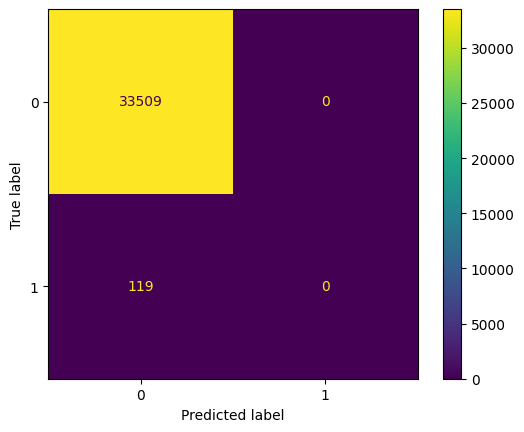

In [23]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

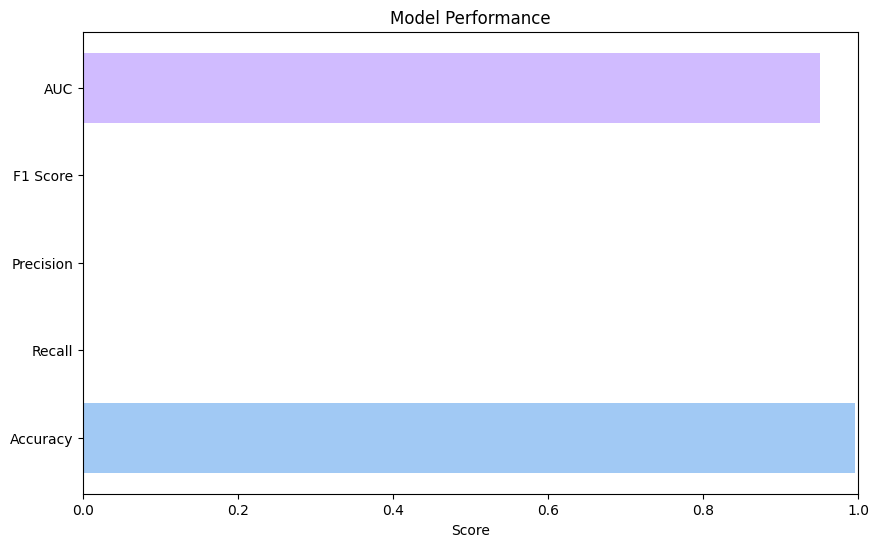

In [24]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [26]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Compute precision and recall values
precision2, recall2, _ = precision_recall_curve(y_test, y_pred)

# Calculate the area under the precision-recall curve (PRAUC)
prauc = auc(recall2, precision2)

print('PRAUC:', prauc)

ap = average_precision_score(y_test, y_pred)
print('average_precision_score', ap)

PRAUC: 0.10737762987464942
average_precision_score 0.11204083852266983


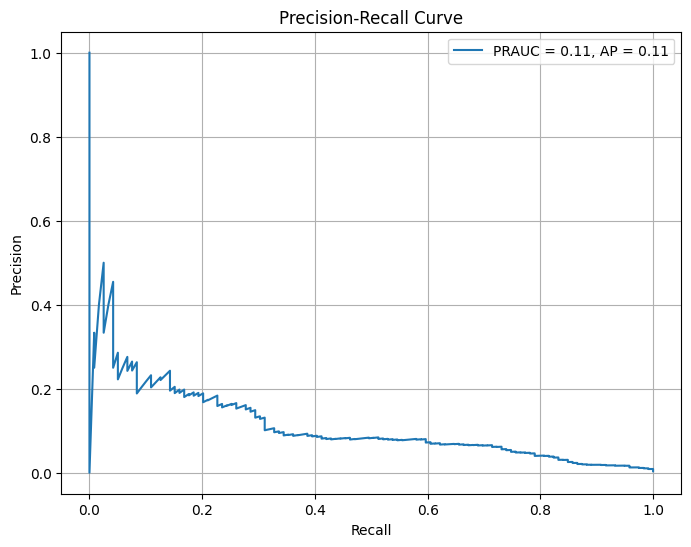

In [27]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall2, precision2, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [28]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
19          net_working_capital        1962
15              DTDmedianNonFin        1498
20                   debt_ratio        1444
31     working_capital_turnover        1388
10                          m2b        1326
26               asset_turnover        1288
21         debt_to_equity_ratio        1240
28            days_in_inventory        1233
41                         macd        1173
8                     sizelevel        1171
43                       macd_s        1168
17                  quick_ratio        1156
4                liqnonfinlevel        1154
22                 equity_ratio        1147
25             return_on_assets        1102
11                        sigma        1087
6                    ni2talevel        1072
2                      dtdlevel        1070
29         receivables_turnover        1064
1                         STInt        1045
42                       macd_h        1028
5                liqnonfintrend 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


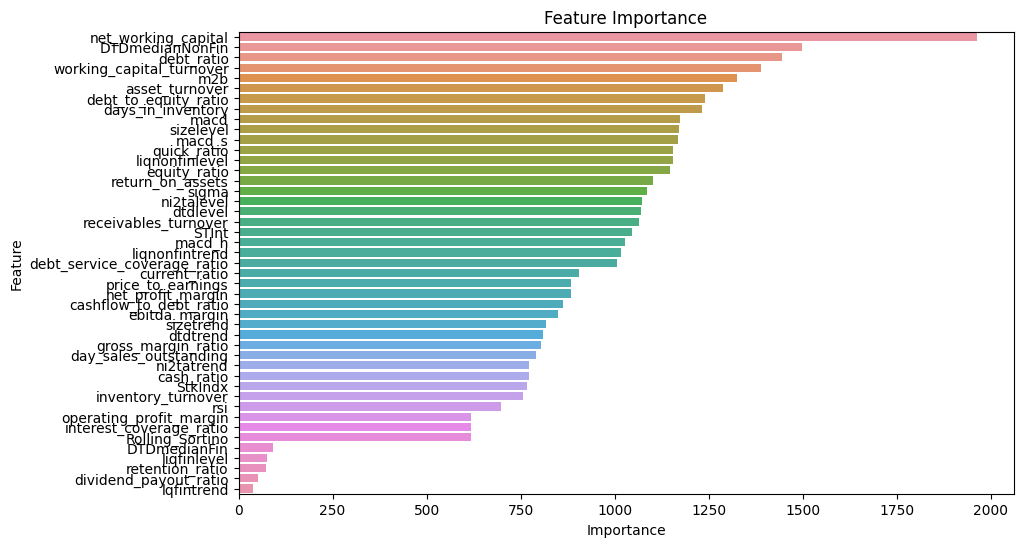

In [29]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

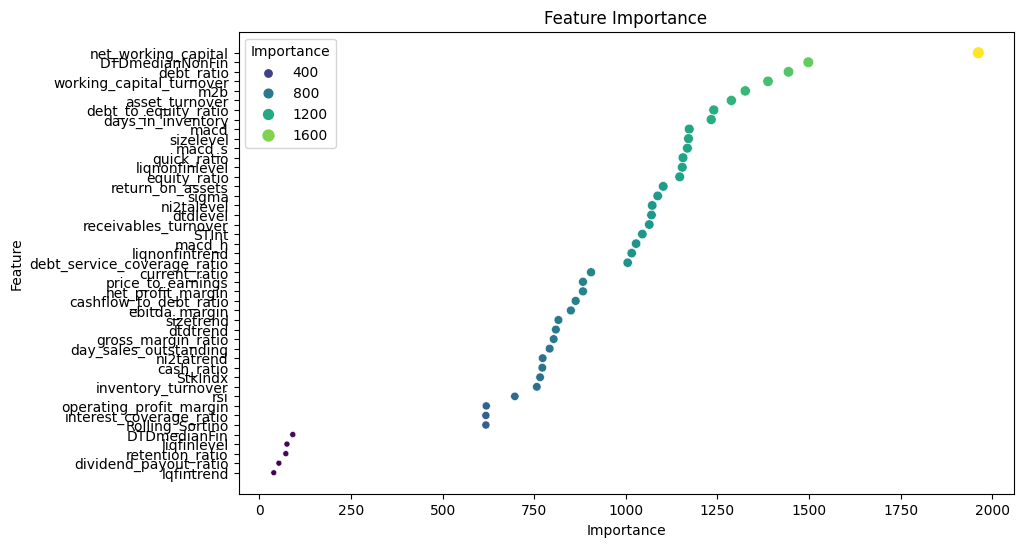

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

Load one model and Plot performances